# Structure électronique du $Na_2Te$
#### Vaessen Louise, 59762100.

### Importation des packages et des données nécessaires

In [26]:
import numpy as np
from math import pow
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from matplotlib import pyplot as plt

In [27]:
mp_key = "iHKrsQ8aWfQ1QaXnodlQAIOBI4QNOfIj"
mp_id = "mp-2784"

In [28]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

### Représentation de la structure de bande électronique et de la densité d'état associée.

In [38]:
fig_el_bs_and_dos = get_plot_bs_and_dos(el_bs, el_dos, plot_range=[-4,12])
fig_el_bs_and_dos.show()

Le parcours défini par les vecteurs d'ondes est représenté ci dessous dans la zone de Brillouin. 

In [39]:
plot_brillouin_zone(el_bs.structure)

# Bande interdite

In [40]:
# Représentation du minimum et de maximum de la bande interdite. 

fig_el_bs = get_plot_bs(el_bs, plot_range=[-4,7])
xvals = fig_el_bs.to_dict()["data"][0]["x"]
yvals_vbm = fig_el_bs.to_dict()["data"][2]["y"]
yvals_cbm = fig_el_bs.to_dict()["data"][3]["y"]

In [41]:
xvals_band_edges = []
yvals_band_edges = []
for i in el_bs.get_vbm()["kpoint_index"]:
    xvals_band_edges.append(xvals[i])
    yvals_band_edges.append(yvals_vbm[i])
for i in el_bs.get_cbm()["kpoint_index"]:
    xvals_band_edges.append(xvals[i])
    yvals_band_edges.append(yvals_cbm[i])

In [42]:
for i in el_bs.get_vbm()["kpoint_index"]:
    scatter = go.Scatter(
        x = xvals_band_edges, y = yvals_band_edges,
        mode = "markers", marker = dict(color="black"),
        showlegend=False)
    fig_el_bs.add_trace(scatter)
fig_el_bs.update_layout(xaxis_range = [xvals[0], xvals[-1]])
fig_el_bs.show()

In [43]:
direct = el_bs.get_band_gap()['direct']
band_gap = el_bs.get_band_gap()['energy']
transition = el_bs.get_band_gap()['transition']
print("Bande interdite déterminée par : ")
print("Écart direct : " + str(direct))
print("Énergie de transition : " + str(band_gap) + " eV")
print("Point de transition : " + str(transition))

Bande interdite déterminée par : 
Écart direct : True
Énergie de transition : 2.0282 eV
Point de transition : \Gamma-\Gamma


L'énergie nécessaire minimale à apporter pour passer de la bande de valence à la bande de conduction vaut : 2.0282 eV. Il s'agit de l'énergie que l'électron doit acquérir pour passer de la bande de valence (localisé près du noyau atomique) à la bande de conduction (l'électron peut librement circuler dans le cristal), où il participera à la conductivité électrique. Cette transition minimale se passe au point Gamma du réseau réciproque et étant donné que  la transition est directe, elle se passe pour un seul vecteur d'onde k. 
On peut remarquer que l'énergie à apporter est supérieure à 2 eV, ce qui implique que le matériau est un isolant. 
La bande interdite est donc située entre les bandes 10 et 11 sur le dessin. 

# Dispersion des électrons

La dispersion sur une bande électronique représente la variation de l'énergie des électrons en fonction de leur vecteur d'onde. Pour avoir le maximum de dispertion sur une bande, je dois rechercher la direction dans la zone de Brillouin où la pente est maximale. Voici ci dessous les directions correspondant au maximum et au minimum de dispersion pour la dernière bande de valence et la remière bande de conduction. 

In [44]:
data = BSPlotter(el_bs).bs_plot_data()
distance = data.get('distances') # Tableau d'arrays contenant les différents segments. 
energie = data.get('energy')

# Calcul de la pente pour chaque tableau. 

# Pour la bande de conduction : 

pente_max_cond = 0
i_max_cond = 0
pente_min_cond = np.inf
i_min_cond = 0

for i in range(len(distance)) : 
    last_elem_distance = len(distance[i]) - 1
    last_elem_energie = len(energie.get('1')[i][10]) - 1
    pente = (energie.get('1')[i][10][last_elem_energie] - energie.get('1')[i][10][0])/(distance[i][last_elem_distance] - distance[i][0])
    if(np.abs(pente) > np.abs(pente_max_cond)) : 
        pente_max_cond = pente
        i_max_cond = i
        
    if np.abs(pente) < np.abs(pente_min_cond) : 
        pente_min_cond = pente
        i_min_cond = i


# Pour la bande de valence : 

pente_max_val = 0
i_max_val = 0
pente_min_val = np.inf
i_min_val = 0

for i in range(len(distance)) : 
    last_elem_distance = len(distance[i]) - 1
    last_elem_energie = len(energie.get('1')[i][9]) - 1
    pente = (energie.get('1')[i][9][last_elem_energie] - energie.get('1')[i][9][0])/(distance[i][last_elem_distance] - distance[i][0])
    if(np.abs(pente) > np.abs(pente_max_val)) : 
        pente_max_val = pente
        i_max_val = i
        
    if np.abs(pente) < np.abs(pente_min_val) : 
        pente_min_val = pente
        i_min_val = i
        

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,9))

# Placement axes verticaux.
location = []
for i in range(len(distance)):
    plt.axvline(distance[i][0],color="black")
    location.append(distance[i][0])
location.append(distance[i][len(distance[i]) - 1])
ax.set_xticks(location)
ax.set_xticklabels(['\u0393','X','W','K','\u0393','L','U','W','L','K|U','X'])
ax.set_xlabel('Wave Vector')
ax.set_ylabel('E-Ef (eV)')


# Bande conduction : 
for i in range(len(distance)) : 
    energie_cond = energie.get('1')[i][10]
    dist = distance[i]
    plt.plot(dist, energie_cond, color = 'blue')
    
# Max : 
    
last_elem_distance = len(distance[i_max_cond]) - 1
last_elem_energie = len(energie.get('1')[i_max_cond][10]) - 1
    
plt.arrow(distance[i_max_cond][0], energie.get('1')[i_max_cond][10][0], distance[i_max_cond][last_elem_distance] - distance[i_max_cond][0], energie.get('1')[i_max_cond][10][last_elem_energie] - energie.get('1')[i_max_cond][10][0],color='red',width=0.03,length_includes_head=True, label='Maximum de dispersion')

# Min : 

last_elem_distance = len(distance[i_min_cond]) - 1
last_elem_energie = len(energie.get('1')[i_min_cond][10]) - 1
    
plt.arrow(distance[i_min_cond][0], energie.get('1')[i_min_cond][10][0], distance[i_min_cond][last_elem_distance] - distance[i_min_cond][0], energie.get('1')[i_min_cond][10][last_elem_energie] - energie.get('1')[i_min_cond][10][0],color='green',width=0.03,length_includes_head=True, label = 'Minimum de dispersion')


# Bande de valence : 


for i in range(len(distance)) : 
    energie_cond = energie.get('1')[i][9]
    dist = distance[i]
    plt.plot(dist, energie_cond, color = 'blue')
    
# Max : 
    
last_elem_distance = len(distance[i_max_val]) - 1
last_elem_energie = len(energie.get('1')[i_max_val][9]) - 1
    
plt.arrow(distance[i_max_val][0], energie.get('1')[i_max_val][9][0], distance[i_max_val][last_elem_distance] - distance[i_max_val][0], energie.get('1')[i_max_val][9][last_elem_energie] - energie.get('1')[i_max_val][9][0],color='red',width=0.03,length_includes_head=True)

# Min : 

last_elem_distance = len(distance[i_min_val]) - 1
last_elem_energie = len(energie.get('1')[i_min_val][9]) - 1
    
plt.arrow(distance[i_min_val][0], energie.get('1')[i_min_val][9][0], distance[i_min_val][last_elem_distance] - distance[i_min_val][0], energie.get('1')[i_min_val][9][last_elem_energie] - energie.get('1')[i_min_val][9][0],color='green',width=0.03,length_includes_head=True)

plt.legend()
plt.title("Dispersion des électrons")
plt.show()




On peut voir sur le graphe que le matériau n'est pas isotrope car la dispersion n'est pas identique en toute direction. Ceci implique que ses propriétés peuvent varier selon la direction. Les directions contenant les maximums de dispersion permettent aux porteurs de charges d'atteindre plus de niveaux d'énergie différents, ce qui leur assure une meilleure mobilité. Le matériau sera donc plus conducteur selon ces directions. 
Via la même logique, les minimums de dispersion correspondent aux directions associées à une moins bonne conductivité. 

Pour le $Na_2Te$, le maximum de dispersion pour la dernière bande de valence est selon : W-L, et le minimum selon : Gamma-L.
De même pour la première bande de conduction : le maximum de dispersion est selon : X-W, et le minimum selon : L-U.

# Masse effective

La masse effective est un concept abstrait pour représenter le comportement d'un électron dans un potentiel. Pour le cas d'un électron libre, la dispersion électronique est une parabole. Nous souhaitons conserver ce modèle simple en introduisant un potentiel dans le milieu dans de l'électron. Pour ce faire, on établit le concept de masse effective. On modélise la réponse de l'électron dans ce potentiel en variant sa masse. Il s'agit bien d'un modèle abstrait, l'électron conservant toujours une masse de $9,109.10^{-31}$ kg. On peut remarquer que la masse effective d'un électron dans le vide est égale à la masse réelle de l'électron. 

La masse effective est calculée comme étant l'inverse de la dérivée seconde de l'énergie par rapport au vecteur d'onde k (corrigée par quelques facteurs pour correspondre aux bonnes unités). Elle est exprimée en kg. On peut interpréter cette équation comme étant la réponse de l'électron en accélération, lorsqu'il est soumis à une force dans un potentiel.

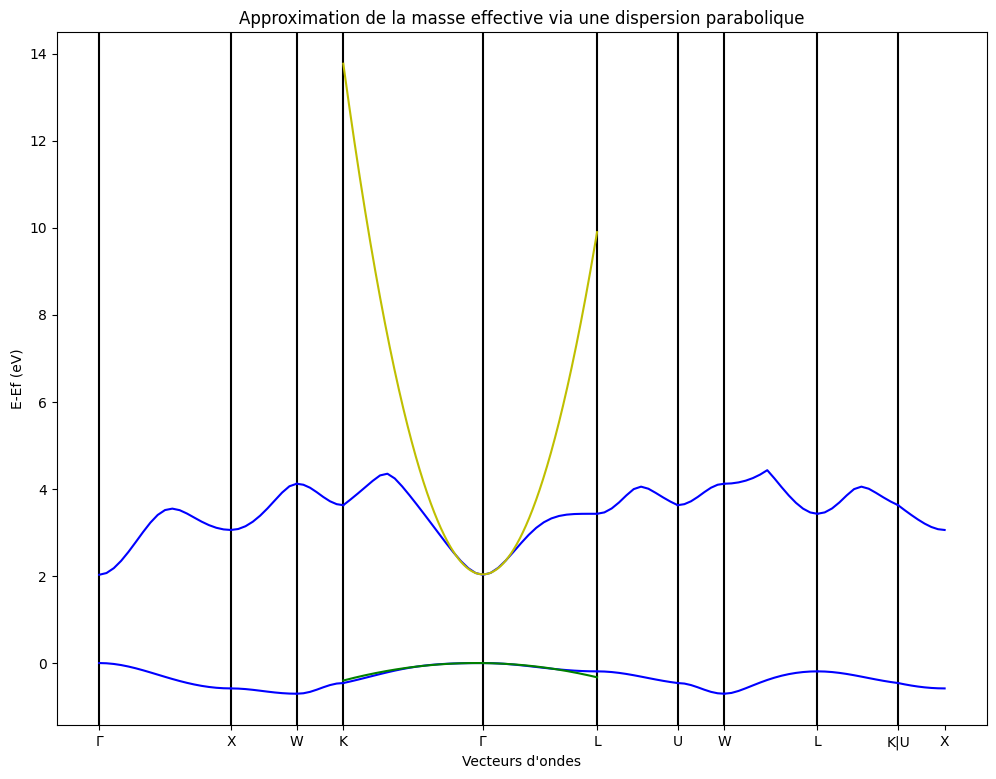

Bande de valence : 
Parabole approximant la dernière bande de valence à son sommet : 
       y(k) = -0.5344485166944645k² + 2.6258621583018282k -3.2247471881141934
Dérivée seconde de la courbe = -1.068897033388929 eVÅ²
Masse effective au sommet de la dernière bande de valence = -1.1197517852006247e-36 kg



Bande de conduction : 
Parabole approximant la première bande de conduction à sa base : 
       y(k) = 14.229301787584482k² -71.05377130600438k + 90.73943055720095
Dérivée seconde de la courbe = 28.458603575168965 eVÅ²
Masse effective au sommet de la dernière bande de valence = 2.9812574235125e-35 kg


In [48]:
fig,ax = plt.subplots(1,1,figsize=(12,9))

# Placement axes verticaux.
location = []
for i in range(len(distance)):
    plt.axvline(distance[i][0],color="black")
    location.append(distance[i][0])
location.append(distance[i][len(distance[i]) - 1])
ax.set_xticks(location)
ax.set_xticklabels(['\u0393','X','W','K','\u0393','L','U','W','L','K|U','X'])
ax.set_xlabel("Vecteurs d'ondes")
ax.set_ylabel("E-Ef (eV)")


# Bande conduction : 
for i in range(len(distance)) : 
    energie_cond = energie.get('1')[i][10]
    dist = distance[i]
    plt.plot(dist, energie_cond, color = 'blue')
    
x_cond = []
for i in range(int(len(distance[3])*3/4), len(distance[3])) : 
    x_cond.append(distance[3][i])
for i in range(int(len(distance[4])/4)) : 
    x_cond.append(distance[4][i])

y_cond = []
for i in range(int(len(energie.get('1')[3][10])*3/4), len(energie.get('1')[3][10])) : 
    y_cond.append(energie.get('1')[3][10][i])
for i in range(int(len(energie.get('1')[4][10])/4)) : 
    y_cond.append(energie.get('1')[4][10][i])

a_cond = np.polyfit(x_cond,y_cond,2)
x_cond = np.linspace(distance[3][0],distance[4][-1],1000)

plt.plot(x_cond,np.polyval(a_cond,x_cond),'y') 


# Bande de valence.
for i in range(len(distance)) : 
    energie_cond = energie.get('1')[i][9]
    dist = distance[i]
    plt.plot(dist, energie_cond, color = 'blue')

x_val = []
for i in range(int(len(distance[3])*3/4), len(distance[3])) : 
    x_val.append(distance[3][i])
for i in range(int(len(distance[4])/4)) : 
    x_val.append(distance[4][i])

y_val = []
for i in range(int(len(energie.get('1')[3][9])*3/4), len(energie.get('1')[3][9])) : 
    y_val.append(energie.get('1')[3][9][i])
for i in range(int(len(energie.get('1')[4][9])/4)) : 
    y_val.append(energie.get('1')[4][9][i])

a = np.polyfit(x_val,y_val,2)

x_val = np.linspace(distance[3][0],distance[4][-1],1000)
plt.plot(x_val,np.polyval(a,x_val),'g')
plt.title("Approximation de la masse effective via une dispersion parabolique")

plt.show()


print("Bande de valence : ")
print("Parabole approximant la dernière bande de valence à son sommet : \n       y(k) = "+str(a[0])+"k\u00b2 + "+str(a[1])+"k "+str(a[2]))
derivee2 = a[0]*2
print("Dérivée seconde de la courbe = " + str(derivee2) + " eV\u212b\u00b2")
print("Masse effective au sommet de la dernière bande de valence = " + str((6.62607004*10**(-34))/((2*np.pi)**2*pow(derivee2, -1)*1.602176634*10)) + " kg")

print("\n\n")
print("Bande de conduction : ")
print("Parabole approximant la première bande de conduction à sa base : \n       y(k) = "+str(a_cond[0])+"k\u00b2 "+str(a_cond[1])+"k + "+str(a_cond[2]))
derivee2_cond = a_cond[0]*2
print("Dérivée seconde de la courbe = " + str(derivee2_cond) + " eV\u212b\u00b2")
print("Masse effective au sommet de la dernière bande de valence = " + str((6.62607004*10**(-34))/((2*np.pi)**2*pow(derivee2_cond, -1)*1.602176634*10)) + " kg")

La masse effective située au sommet de la bande de valence est donc $-1,1198.10^{-36}$ kg. Celle pour la bande de conduction est : $2.9813.10^{-35}$ kg.

La masse effective associée au sommet de la bande de valence est donc négative. Ce résultat n'est pas absurde car il s'agit d'un concept abstrait. Cela implique simplement que l'accélération de l'électron se fait dans la même direction, mais dans le sens opposé à la force (due au potentiel) qu'il subit. 

La masse d'un électron vaut $9,109.10^{-31}$ kg. Donc, les électrons situés aux deux points précisés plus haut, ont une masse effective inférieure à la masse absolue d'un électron. L'électron se comporte comme si il était plus léger. Donc, sa réponse par rapport au potentiel auquel il est soumis est comme si il accélerait. 

Remarque : l'unité du vecteur d'onde k est le $\mathring{A}^{-1}$ et celle de l'énergie l'eV.            1$\mathring{A}$ = $10^{-10}$m et 1eV = $1,60218.10^{-19}$ J.